In [1]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [3]:
# Selecting Features
X = df.drop('target', axis=1)
y = df['target']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

In [5]:
# Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
models = {
    'Logistic Regression' : LogisticRegression(max_iter=10),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(n_estimators=50),
    'Gradient Boosting' : GradientBoostingClassifier(),
    'SVM' : SVC(),
    'KNN' : KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes' : GaussianNB()
}

In [7]:
train_accuracies = {}
test_accuracies = {}
classification_reports = {}

for name, model in models.items():
    if name in ["Logistic Regression", "KNN", "SVM", "Naive Bayes"]:
        # Models that need scaled input
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
    else:
        # Tree-based models (do not need scaling)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

    # Accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Store results
    train_accuracies[name] = train_acc
    test_accuracies[name] = test_acc
    classification_reports[name] = classification_report(y_test, y_test_pred, output_dict=True)

    # Print results
    print("="*60)
    print(f" Model: {name}")
    print("Training Accuracy:", round(train_acc, 4))
    print("Testing Accuracy :", round(test_acc, 4))
    print(classification_report(y_test, y_test_pred))

 Model: Logistic Regression
Training Accuracy: 0.8598
Testing Accuracy : 0.8146
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       103
           1       0.79      0.86      0.82       102

    accuracy                           0.81       205
   macro avg       0.82      0.81      0.81       205
weighted avg       0.82      0.81      0.81       205

 Model: Decision Tree
Training Accuracy: 1.0
Testing Accuracy : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00       102

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

 Model: Random Forest
Training Accuracy: 1.0
Testing Accuracy : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.

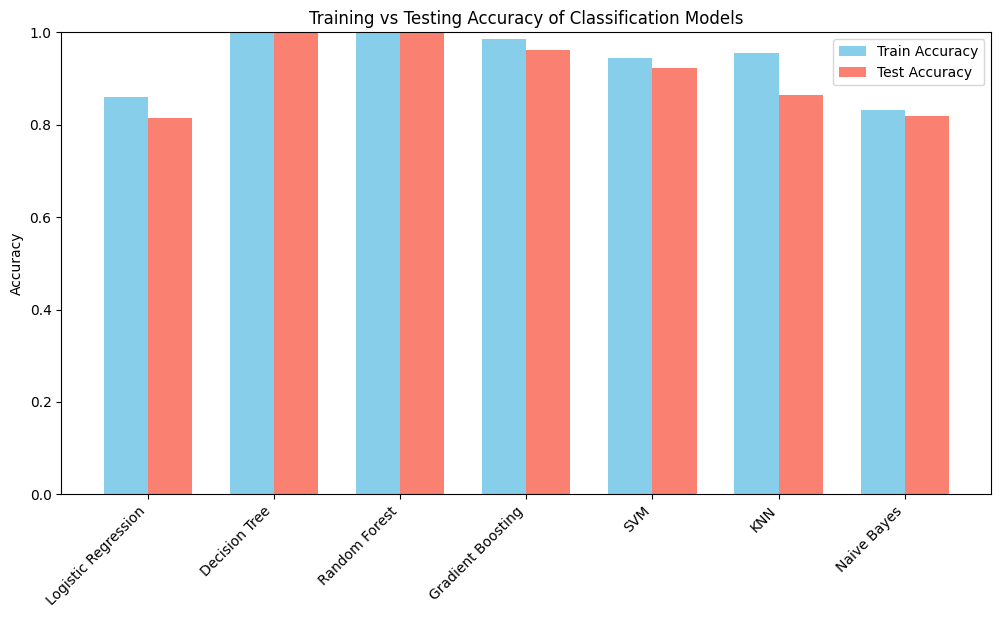

In [8]:
# Plot accuracy comparison
plt.figure(figsize=(12,6))
bar_width = 0.35
models_list = list(models.keys())
x = range(len(models_list))

plt.bar(x, [train_accuracies[m] for m in models_list],
        width=bar_width, label="Train Accuracy", color="skyblue")
plt.bar([i+bar_width for i in x], [test_accuracies[m] for m in models_list],
        width=bar_width, label="Test Accuracy", color="salmon")

plt.title("Training vs Testing Accuracy of Classification Models")
plt.ylabel("Accuracy")
plt.xticks([i + bar_width/2 for i in x], models_list, rotation=45, ha="right")
plt.ylim(0, 1)
plt.legend()
plt.show()

# ***The current visualization compares the training and testing accuracy of different classification models.***


*   Some models (e.g., Random Forest and Decision Tree) are performing extremely well but may risk overfitting since the training accuracy is very close to 1.0.
*   Other models (e.g., Logistic Regression, KNN, Naive Bayes) show slightly lower accuracy, which suggests they may be underfitting compared to more complex models.

### To address this and ensure that we select the best model with the right balance between bias and variance, we will now apply GridSearchCV.

-----------------------------------------------------------------------------------

# ***What is GridSearchCV?***

GridSearchCV is a tool in scikit-learn that helps you find the best hyperparameters for a machine learning model.

## Think of it as:


*   Grid = a table of all possible parameter combinations you want to try.
*   Search = test each combination one by one.
*   CV (Cross Validation) = instead of testing only once, it splits the training data into multiple parts to check stability.

GridSearchCV is like a brute-force search over all parameter combinations, but done smartly with cross-validation to avoid overfitting.

In [9]:
# Define hyperparameter grids
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1],  # smaller values = stronger regularization
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"]
    },
    "KNN": {
        "n_neighbors": [5, 7, 9, 11, 15],  # larger k = smoother decision boundary
        "weights": ["uniform", "distance"],
        "p": [1, 2]  # Manhattan, Euclidean
    },
    "SVM": {
        "C": [0.01, 0.1, 1],  # smaller C = simpler model
        "kernel": ["linear", "rbf"],
        "gamma": ["scale"]  # avoid "auto" which can overfit
    },
    "Decision Tree": {
        "max_depth": [3, 5, 7],  # restrict depth
        "min_samples_split": [5, 10, 20],  # require more samples to split
        "min_samples_leaf": [5, 10, 20]  # require more samples per leaf
    },
    "Random Forest": {
        "n_estimators": [50, 100],  # fewer trees
        "max_depth": [5, 10, 15],  # restrict depth
        "min_samples_split": [5, 10, 20],
        "min_samples_leaf": [5, 10, 20]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.05, 0.1],  # lower learning rate
        "max_depth": [3, 5],  # shallow trees
        "min_samples_split": [5, 10, 20],
        "min_samples_leaf": [5, 10, 20],
        "subsample": [0.7, 0.8, 0.9]  # use fraction of data
    },
    "Naive Bayes": {  # GaussianNB
        "var_smoothing": [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]
    }
}


## ***It trains and validates each combination***


*   It doesn’t just check on the training set once.
*   It does k-fold cross-validation (splits training data into k smaller parts).
*   Example: With cv=5, it trains on 4 folds, tests on 1 fold, and repeats 5 times.

# ***It picks the best combination***


*   The one with the highest average accuracy (or whichever scoring metric you chose).

# ***Example***

### Imagine you have 100 data samples.
### If you just split them once into train (80) and test (20), the result might depend too much on which 20 you picked.

### So instead, in 5-fold CV (cv=5):


1.   Split your dataset into 5 equal parts (folds).
  *   Fold 1 → 20 samples
  *   Fold 2 → 20 samples
  *   Fold 3 → 20 samples
  *   Fold 4 → 20 samples
  *   Fold 5 → 20 samples


2.   Now, the model is trained 5 different times, each time using 4 folds for training and 1 fold for testing:
  *   Run 1: Train on folds 2,3,4,5 → Test on fold 1
  *   Run 2: Train on folds 1,3,4,5 → Test on fold 2
  *   Run 3: Train on folds 1,2,4,5 → Test on fold 3
  *   Run 4: Train on folds 1,2,3,5 → Test on fold 4
  *   Run 5: Train on folds 1,2,3,4 → Test on fold 5

3.   After all 5 runs, GridSearchCV takes the average accuracy across the 5 test folds.


This way, the model is tested on all data at some point, but never trained and tested on the same data at the same time.





In [10]:
best_models = {}
best_scores = {}

# Loop over models and tune
for name, model in models.items():
    print("="*60)
    print(f"Tuning {name}...")

    # Choose scaled or unscaled data
    if name in ["Logistic Regression", "KNN", "SVM"]:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
    else:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)

    # Store best model and accuracy
    best_models[name] = best_model
    best_scores[name] = accuracy_score(y_test, y_pred)

     # Print results
    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Best CV Score: {grid.best_score_:.4f}")
    print(f"Test Accuracy: {best_scores[name]:.4f}")
    print(classification_report(y_test, y_pred))

Tuning Logistic Regression...
Best Params for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.8537
Test Accuracy: 0.8195
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       103
           1       0.78      0.88      0.83       102

    accuracy                           0.82       205
   macro avg       0.82      0.82      0.82       205
weighted avg       0.82      0.82      0.82       205

Tuning Decision Tree...
Best Params for Decision Tree: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best CV Score: 0.8866
Test Accuracy: 0.8829
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       103
           1       0.87      0.90      0.88       102

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205

Tuning Random Forest

In [11]:
# Compare Best Models
print("Final Comparison of Best Models:\n")
for name, acc in best_scores.items():
    print(f"{name}: {acc:.4f}")

Final Comparison of Best Models:

Logistic Regression: 0.8195
Decision Tree: 0.8829
Random Forest: 0.9268
Gradient Boosting: 1.0000
SVM: 0.9220
KNN: 1.0000
Naive Bayes: 0.8146


# ***Key points***
*   param_grid = all possible settings to try.
*   GridSearchCV = brute-force search for best settings.
*   grid.best_estimator_ = the model with the best settings.
*   grid.best_params_ = the actual parameters chosen.

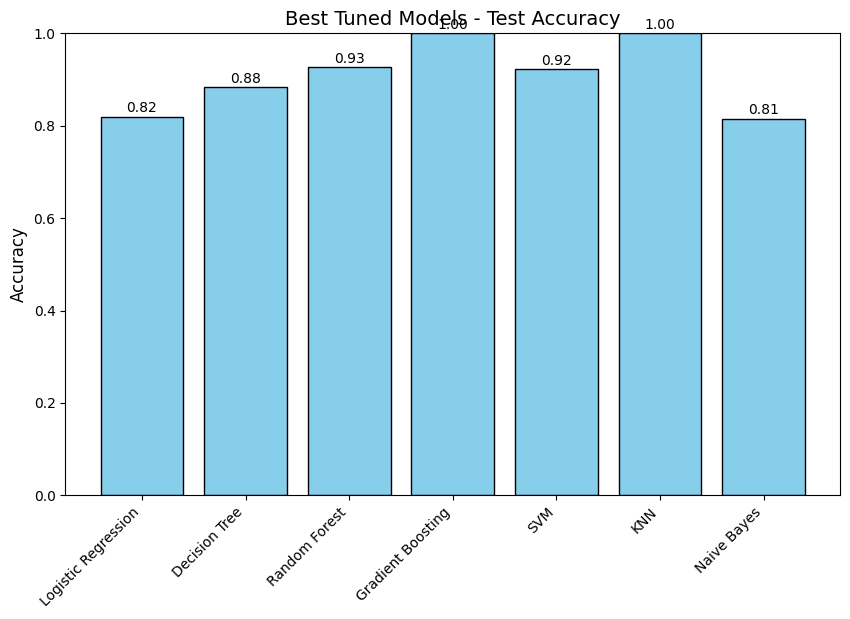

In [12]:
plt.figure(figsize=(10,6))
plt.bar(best_scores.keys(), best_scores.values(), color="skyblue", edgecolor="black")

plt.title("Best Tuned Models - Test Accuracy", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)

for i, acc in enumerate(best_scores.values()):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center", fontsize=10)

plt.show()

# ***📝 Final Comment***


*   The results show that **KNN** and **Gradient Boosting** achieved perfect accuracy (100%) on the test set. While this looks impressive, such results often indicate overfitting, meaning the model may not generalize well to new, unseen data.

*   On the other hand, **SVM (92%)** and **Random Forest (92%)** achieved high accuracy without reaching a suspiciously perfect score. This balance suggests they are **more reliable and generalizable models** for this dataset.

### Therefore, the best models in this case are **SVM** and **Random Forest**, as they provide strong accuracy while reducing the risk of overfitting.

In [17]:
from sklearn.pipeline import Pipeline
import joblib

In [18]:
# Create pipeline (scaler + model)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(C=1, kernel="rbf", gamma="scale"))
])

In [19]:
# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC(C=1))])

In [20]:
# Save model
joblib.dump(pipeline, "final_model.pkl")

['final_model.pkl']